# CIFAR-10: Image Dataset

We will take a deep dive into data preparation by implementing our own datasets and dataloader using numpy. 

In this notebook, we will focus on the image dataset CIFAR-10. The CIFAR-10 dataset consists of 50000 32x32 colour images in 10 classes, which are *plane*, *car*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*.

Let's start by importing some libraries that we will need along the way, as well as some code files that we will work on throughout this notebook.

In [1]:
import os
import pickle

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from dl_zero2one.data import (
    ImageFolderDataset,
    RescaleTransform,
    NormalizeTransform,
    ComposeTransform,
    compute_image_mean_and_std,
)
from dl_zero2one.tests import (
    save_pickle
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1. Dataset Download
Let us get started by downloading the data. In `dl_zero2one/data/image_folder_dataset.py` we can find a class `ImageFolderDataset`, which we will have to complete throughout this notebook.

This class automatically downloads the raw data for us. To do so, simply initialize the class as below:

In [2]:
# Set up the output dataset folder
working_path = os.path.dirname(os.path.abspath(os.getcwd()))
cifar_root = os.path.join(working_path, "datasets", "cifar10")

# Init the dataset and display downloading information this one time
dataset = ImageFolderDataset(
    root=cifar_root,
    force_download=False,
    verbose=True
)

Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'


We should now be able to see the images in `datasets/cifar10` in our file browser, which should contain one subfolder per class, each containing the respective images labeled `0001.png`, `0002.png`, ...

By default, the dataset will only be downloaded the first time we initialize a dataset class. If, for some reason, our version of the dataset gets corrupted and we wish to re-download it, simply initialize the class with `force_download=True` in the download cell above.

## 2. Data Visualization

Before training any model we should *always* take a look at some samples of our dataset. In this way, we can make sure that the data input has worked as intended and also get a feeling for the dataset. 

Let's load the CIFAR-10 data and visualize a subset of the images. To do so, `PIL.Image.open()` is used to open an image, and then `numpy.asarray()` to cast the image to a numpy array, which will have shape 32x32x3. In this way 7 images will be loaded per class, and then use `matplotlib.pyplot` to visualize those images in a grid.

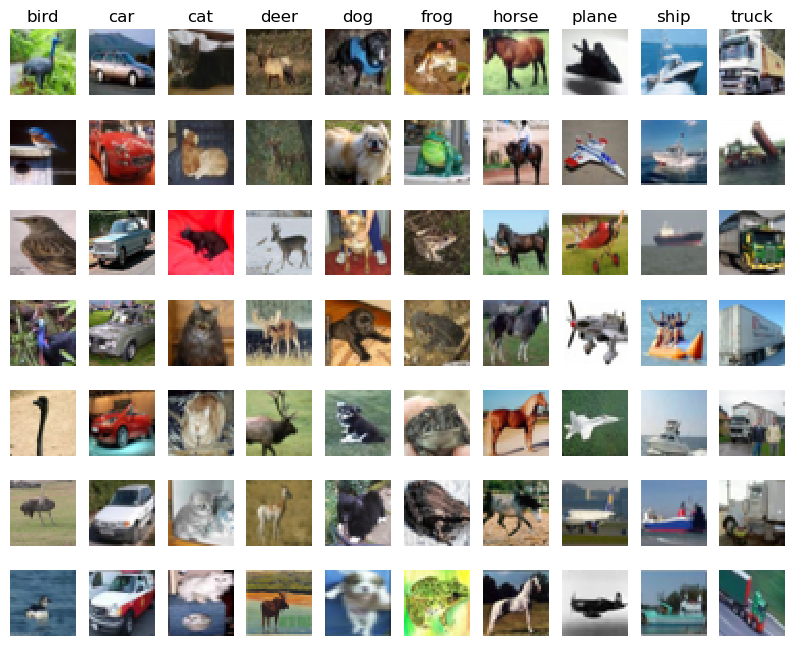

In [3]:
def load_image_as_numpy(image_path):
    return np.asarray(Image.open(image_path), dtype=float)

classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
]
num_classes = len(classes)
samples_per_class = 7
for label, cls in enumerate(sorted(classes)):
    for i in range(samples_per_class):
        image_path = os.path.join(
            cifar_root,
            cls,
            str(i+1).zfill(4) + ".png"
        )  # e.g. cifar10/plane/0001.png
        image = np.asarray(Image.open(image_path))  # open image as numpy array
        plt_idx = i * num_classes + label + 1  # calculate plot location in the grid
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(image.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)  # plot class names above columns
plt.show()

## 3. ImageFolderDataset Implementation

Loading images following steps above is a bit cumbersome. Therefore, we use a custom **Dataset** class, which takes care of the data loading. This is always the first thing we have to implement when starting a new deep learning project.

### 3.1 Dataset Class

The **Dataset** class is a wrapper that loads the data from a given file path and returns a dictionary containing already prepared data, as we have done above. Datasets always need to have the following two methods implemented:
- `__len__(self)` is a method that should simply calculate and return the number of images in the dataset. After it is implemented, we can simply call it with `len(dataset)`.
- `__getitem__(self, index)` should return the image with the given index from our dataset. Implementing this will allow us to access our dataset like a list, i.e. we can then simply call `dataset[9]` to access the 10th image in the dataset.

Generally, we will have to implement a different dataset for every project.

### 3.2 ImageFolderDataset Implementation

Now let's have a look at such a dataset class for CIFAR-10. To do so, we open `dl_zero2one/data/image_folder_dataset.py` and check the following three methods of `ImageFolderDataset`:
- `make_dataset(directory, class_to_idx)` loads the prepared data from a given directory root (`directory`) into two lists (`images` and `labels`). `class_to_idx` is a dict mapping class (e.g. 'cat') to label (e.g. 1).
- `__len__(self)` calculates and return the number of images in our dataset.
- `__getitem__(self, index)` returns the image with the given index from our dataset.

In [4]:
dataset = ImageFolderDataset(
    root=cifar_root,
)

In [5]:
len(dataset)

30000

### 3.3 Dataset Usage

Using the `__getitem__()` method, we can now access our dataset as conveniently as we would access a list:

In [6]:
sample_item = dataset[0]
sample_image = sample_item["image"]
sample_label = sample_item["label"]

print('Sample image shape:', sample_image.shape)
print('Sample label:', sample_label)
print('Sample image first values:', sample_image[0][0])

Sample image shape: (32, 32, 3)
Sample label: 2
Sample image first values: [129. 129. 129.]


The images are represented as uint8 values for each of the three RGB color channels. The data type and scale will be important later.

As we have implemented both `__len__()` and `__getitem__()`, we can now even iterate over the dataset with a simple for loop! 

In [7]:
num_samples = 0
for sample in tqdm(dataset):
    num_samples += 1
    
print("Number of samples:", num_samples)

100%|██████████| 30000/30000 [00:08<00:00, 3736.23it/s]

Number of samples: 30000


## 4. Transforms and Image Preprocessing

Before training machine learning models, we often need to pre-process the data. For image datasets, two commonly applied techniques are:
1. Normalize all images so that each value is either in [-1, 1] or [0, 1]. By doing so the image are also converted to floating point numbers.
2. Compute the mean over all images and subtract this mean from all images in the dataset

These transform classes are callables, meaning that we will be able to simply use them as follows:

```transform = Transform()```

```images_transformed = transform(images)```

This will be realized in the pipeline by defining so called transforms. Instead of applying them globally to the input data, we will apply those seperatly to each sample after loading it in the `__getitem__` call of the dataset.

In [8]:
dataset = ImageFolderDataset(
    root=cifar_root,
)

Equipped with this change, we can now easily add the two preprocessing techniques above for CIFAR-10. We will do so in the following steps by implementing the classes `RescaleTransform` and `NormalizeTransform` in `dl_zero2one/data/transforms.py`.

### 4.1 Rescaling Images using RescaleTransform

Let's start by using `RescaleTransform`. If we look at the `__init__()` method, we will notice it has four arguments:
* **out_range** is the range we wish to rescale our images to. E.g. if we want to scale our images to [-1, 1], we would use `range=(-1, 1)`. By default, they will be scaled to [0, 1].
* **in_range** is the value range of the data prior to rescaling. For uint8 images, this will always be (0, 255).

In [9]:
rescale_transform = RescaleTransform()
dataset_rescaled = ImageFolderDataset(
    root=cifar_root,
    transform=rescale_transform
)

If we look at the first image, we should now see that all values are between 0 and 1.

In [10]:
sample_item = dataset_rescaled[0]
sample_label = sample_item["label"]
sample_image = sample_item["image"]

print("Max value:", np.max(sample_image))
print("Min value:", np.min(sample_image))
print('Sample rescaled image first values:', sample_image[0][0])

Max value: 0.6470588235294118
Min value: 0.00392156862745098
Sample rescaled image first values: [0.50588235 0.50588235 0.50588235]


### 4.2 Normalize Images to Standard Gaussian using NormalizeTransform

Let us now move on to the `NormalizeTransform` class. The `NormalizeTransform` class normalizes images channel-wise and its `__init__` method has two arguments:
* **mean** is the normalization mean, which will be subtracted from the dataset.
* **std** is the normalization standard deviation. By scaling the data with a factor of `1/std` the standard deviation will be normazlied accordingly.

Have a look at the code in `dl_zero2one/data/transforms.py`.

The next step is to normalize the CIFAR-10 **images channel-wise** to standard normal. To do so, we need to calculate the **per-channel image mean and standard deviation** first, which we can then provide to `NormalizeTransform` to normalize the data accordingly.

In [11]:
# We first have to load all rescaled images
rescaled_images = []
for sample in tqdm(dataset_rescaled):
    rescaled_images.append(sample["image"])
rescaled_images = np.array(rescaled_images)

100%|██████████| 30000/30000 [00:04<00:00, 7340.81it/s]


In [12]:
cifar_mean, cifar_std = compute_image_mean_and_std(rescaled_images)
print("Mean:\t", cifar_mean, "\nStd:\t", cifar_std)

Mean:	 [0.49088065 0.48219695 0.4471636 ] 
Std:	 [0.24712473 0.24371225 0.2618626 ]


In [13]:
# The rescaled images will be deleted now from ram as they are no longer needed
try:
    del rescaled_images
except NameError:
    pass

Now we can use the mean and standard deviation we computed to normalize the loaded data. This can be done by simply adding the `NormalizeTransform` to the list of transformations our dataset applies in `__getitem__()`.

We can use ```ComposeTransform``` in ```transforms.py``` to chain multiple transforms.

In [14]:
# Set up both transforms using the parameters computed above
rescale_transform = RescaleTransform()
normalize_transform = NormalizeTransform(
    mean=cifar_mean,
    std=cifar_std
)

final_dataset = ImageFolderDataset(
    root=cifar_root,
    transform=ComposeTransform([rescale_transform, normalize_transform])
)

We can now check out the results of the transformed samples:

In [15]:
sample_item = final_dataset[0]
sample_label = sample_item["label"]
sample_image = sample_item["image"]

print('Sample normalized image shape:', sample_image.shape)
print('Sample normalized image first values:', sample_image[0][0])

Sample normalized image shape: (32, 32, 3)
Sample normalized image first values: [0.06070499 0.09718595 0.22423497]


## 5. Save the Dataset
Now save the dataset and transforms using the following cell. This will save it to a pickle file `models/cifar_dataset.p`. We will use this dataset for the next notebook.

In [16]:
save_pickle(
    data_dict={
        "dataset": final_dataset,
        "cifar_mean": cifar_mean,
        "cifar_std": cifar_std,
    },
    file_name="cifar_dataset.p"
)

# Key Takeaways
1. Always have a look at the data before starting training any models on it.
2. Datasets should be organized in corresponding **Dataset** classes that support `__len__` and `__getitem__` methods, which allow us to call `len(dataset)` and `dataset[index]`.
3. Data often needs to be preprocessed. Such preprocessing can be implemented in **Transform** classes, which are callables that can be simply applied via `data_transformed = transform(data)`. However, we will rarely do that and apply transforms on the fly using a dataloader which we will introduce in the next notebook.